### Import necessary libraries

In [1]:
import os
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical


2025-01-11 21:46:24.802781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 21:46:24.802815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 21:46:24.802850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 21:46:24.811865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Variables

In [2]:
classes = 43

### Create model

In [3]:
def create_model(input_shape=(32, 32, 3), learning_rate=0.0001):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # Convolutional layer 1
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),

        # Pooling layer 1
        layers.MaxPooling2D((2,2)),

        # Convolutional layer 2
        layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        
        # Pooling layer 2
        layers.MaxPooling2D((2,2)),
        
        # Convolutional layer 3
        layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layer 1
        layers.Dense(256, activation='relu'),
        
        # Dropout layer
        layers.Dropout(0.5),
        
        # Dense layer 2
        layers.Dense(43, activation='softmax')
    ])

    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate)
    
    # Loss
    loss = keras.losses.CategoricalCrossentropy()

    # Compile model
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=['accuracy']
    )

    return model

### Resize all images to 32x32 pixels

In [4]:
def resize_images(size=(32, 32)):
    for i in range(classes):
        input_directory = f"../app/data/train/{i}"
        output_directory = f"../app/data/train-r/{i}"
        
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)
    
        for filename in os.listdir(input_directory):
            input_path = os.path.join(input_directory, filename)
            output_path = os.path.join(output_directory, filename)
    
            try:
                with Image.open(input_path) as img:
                    img = img.resize(size)
                    img.save(output_path)
                    print(f"Resized and saved: {output_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

In [ ]:
resize_images(size=(32, 32))

### Load train images

In [5]:
def load_images():
    
    sign_images = []
    sign_indexes = []

    for i in range(classes):
        
        input_directory = f"../app/data/train-r/{i}"
        
        for filename in os.listdir(input_directory):
            input_path = os.path.join(input_directory, filename)

            try:
                with Image.open(input_path) as img:
                    sign_images.append(np.array(img))
                    sign_indexes.append(i)
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

    sign_images = np.array(sign_images)
    sign_indexes = np.array(sign_indexes)

    return sign_images, sign_indexes

In [6]:
sign_images, sign_indexes = load_images()

### Split train images

In [7]:
# Test folder already exists so we split the sign images into train and validation

X_train, X_val, y_train, y_val = train_test_split(sign_images, sign_indexes, test_size=0.2, random_state=42)

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
sign_images.shape, sign_indexes.shape

((39209, 32, 32, 3), (39209,))

In [10]:
X_train.shape, X_val.shape

((31367, 32, 32, 3), (7842, 32, 32, 3))

In [11]:
y_train.shape, y_val.shape

((31367, 43), (7842, 43))

### Train model

In [12]:
model = create_model(input_shape=(32, 32, 3), learning_rate=0.0001)

2025-01-11 21:47:00.405828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-11 21:47:00.412250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-11 21:47:00.412502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

The model was trained for different **learning rate** values. Below you can see the **valuation accuracy** achieved for each **learning rate** value:

| Learning rate      | 0.1  | 0.01 | 0.001 | 0.0001 |
| :-------------------| :---- | :---- | :----- | :------ |
| Valuation accuracy | 0.06 | 0.63 | 0.98  | 0.99   |

We can see that for learning rate value of **0.0001** we have the best accuracy of **0.99**

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint (
    "./checkpoints/traffic_sign_classification_custom_lr0001_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy"
)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10,
                    batch_size=32,
                    callbacks=[checkpoint]
                   )

Epoch 1/10


2025-01-11 21:47:24.209997: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96359424 exceeds 10% of free system memory.
2025-01-11 21:47:24.396771: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96359424 exceeds 10% of free system memory.
2025-01-11 21:47:25.461164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-01-11 21:47:26.666925: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7b1a1804f300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-11 21:47:26.666950: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-01-11 21:47:26.673518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-11 21:47:26.790284: I ./tensorflow/compiler/jit/device_compiler

981/981 [==============================] - 9s 6ms/step - loss: 2.8431 - accuracy: 0.4002 - val_loss: 0.9901 - val_accuracy: 0.7608
Epoch 2/10
 20/981 [..............................] - ETA: 5s - loss: 1.4249 - accuracy: 0.6187

/home/terminator/github/traffic-sign-classification/py-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 5s 5ms/step - loss: 1.0061 - accuracy: 0.7290 - val_loss: 0.4415 - val_accuracy: 0.9017
Epoch 3/10
981/981 [==============================] - 5s 5ms/step - loss: 0.5543 - accuracy: 0.8475 - val_loss: 0.2455 - val_accuracy: 0.9471
Epoch 4/10
981/981 [==============================] - 5s 5ms/step - loss: 0.3395 - accuracy: 0.9065 - val_loss: 0.1619 - val_accuracy: 0.9662
Epoch 5/10
981/981 [==============================] - 5s 5ms/step - loss: 0.2397 - accuracy: 0.9341 - val_loss: 0.1017 - val_accuracy: 0.9804
Epoch 6/10
981/981 [==============================] - 5s 5ms/step - loss: 0.1773 - accuracy: 0.9520 - val_loss: 0.0755 - val_accuracy: 0.9838
Epoch 7/10
981/981 [==============================] - 5s 5ms/step - loss: 0.1352 - accuracy: 0.9614 - val_loss: 0.0601 - val_accuracy: 0.9878
Epoch 8/10
981/981 [==============================] - 5s 5ms/step - loss: 0.1040 - accuracy: 0.9713 - val_loss: 0.0641 - val_accuracy: 0.9848
Epoch 9/10
981/98

### Plot accuracy and loss

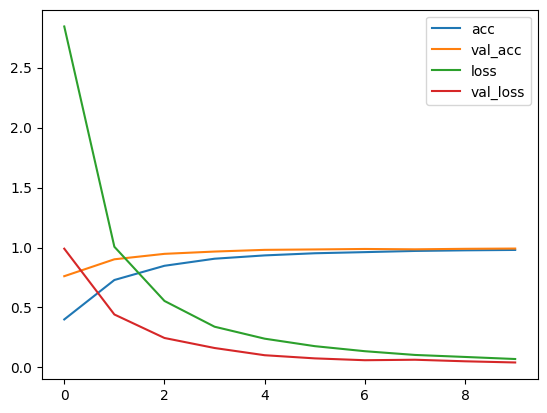

In [14]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In this graph we can see that that **accuracy** and **val_accuracy** values are rising and at the same time **loss** and **val_loss** values are decreasing.

### Make predictions

In [15]:
class_descriptions = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric'
}

In [16]:
# This function gets a traffic sign image as an input and makes a prediction
def make_prediction(image):
    # Load model
    # You can select the file you want from the checkpoints folder
    model = keras.models.load_model('./checkpoints/traffic_sign_classification_custom_lr0001_10_0.991.h5')
    
    # Load image
    img = load_img(image, target_size=(32,32))

    # Create image matrix
    x = np.array(img)
    X = np.array([x])
    print(type(x))
    print(X.shape)
    
    # Make prediction
    pred = model.predict(X)

    # Get class info
    class_index = pred[0].argmax()
    class_name = class_descriptions[class_index]

    # Return info
    return class_index, class_name

In [17]:
image = '../app/data/test/00000.png'

In [18]:
class_index, class_name = make_prediction(image)

<class 'numpy.ndarray'>
(1, 32, 32, 3)
1/1 [==============================] - 0s 187ms/step


In [19]:
class_index, class_name

(16, 'Vehicles over 3.5 metric tons prohibited')